In [16]:
# !python -m pip install gwpy
# !pip install astropy==4.2.1

In [17]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# import os

# One time ONLY - Installation of Kaggle package
# !pip install --upgrade --force-reinstall --no-deps kaggle

# TO IMPORT DATA - ONE TIME CODE
# os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/MyDrive/Kaggle_Datasets'
# os.chdir('/content/gdrive/MyDrive/G2Net_Gravitational_Waves')
# !kaggle competitions download -c g2net-gravitational-wave-detection

#Unzip Data
# !unzip /content/gdrive/MyDrive/G2Net_Gravitational_Waves/g2net-gravitational-wave-detection.zip

In this competition you are provided with a training set of time series data containing simulated gravitational wave measurements from a network of 3 gravitational wave interferometers (LIGO Hanford, LIGO Livingston, and Virgo). Each time series contains either detector noise or detector noise plus a simulated gravitational wave signal. The task is to identify when a signal is present in the data (target=1).

So we need to use the training data along with the target value to build our model and make predictions on the test IDs in form of probability that the target exists for that ID.

So basically data-science helping here by building models to filter out this noises from data-streams (which includes both noise frequencies and Gravitational Waves frequencies) so we can single out frequencies for Gravitational-Waves. This is very well-explained by by Professor Rana Adhikari of Caltech and a member of the LIGO team, who were the first to measure gravitational waves. See his [interview here](https://youtu.be/1D2j8nTjOZ4?t=1946)


## Basic Description of the Data Provided

We are provided with a train and test set of time series data containing simulated gravitational wave measurements from a network of 3 gravitational wave interferometers:

- LIGO Hanford

- LIGO Livingston

- Virgo

Each time series contains either detector noise or detector noise plus a simulated gravitational wave signal.

The task is to identify when a signal is present in the data (target=1).

Each .npy data file contains 3 time series (1 coming for each detector) and each spans 2 sec and is sampled at 2,048 Hz.

And we have a total of 5,60,000 files, each file of dimension of 3 * 4096, this turns out to be a huge time series

In [18]:
import pandas as pd
import seaborn as sns
from scipy import signal
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
from glob import glob
from matplotlib import pyplot as plt
import random
from colorama import Fore, Back, Style
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

## Some basic definition

### What is this .NPY file?

It is a standard binary file format for persisting a single arbitrary NumPy array on disk. The format stores all of the shape and data type information necessary to reconstruct the array correctly even on another machine with a different architecture. The format is designed to be as simple as possible while achieving its limited goals. The implementation is intended to be pure Python and distributed as part of the main numpy package.

**This file format makes incredibly fast reading speed enhancement over reading from plain text or CSV files.**

### Sampling frequency in a TimeSeries

The sampling frequency, or sample rate, is the number of equal-spaced samples per unit of time. For instance, if you have 96 equally spaced observation per day, then you sampling rate is 96/day, or 96/24/3600=0.0011 Hz. Hz, which means per second, is widely used for sample rate.

In [19]:
# Checking the contents of one file
root_dir = "../input/g2net-gravitational-wave-detection"
# file = '../input/g2net-gravitational-wave-detection/train/0/0/0/000a5b6e5c.npy'
file = root_dir + '/train/0/0/0/000a5b6e5c.npy'
data = np.load(file)
print(data.shape)
print(data)
# print(data[0, :].shape)
# print(data[1, :].shape)
# print(data[2, :].shape)
print("data[0, :] is ", data[0, :])
# data_1

(3, 4096)
[[-3.82980864e-21 -3.88290722e-21 -3.89583068e-21 ...
   1.00965251e-20  9.68836567e-21  9.75052802e-21]
 [-5.39587907e-21 -5.86718917e-21 -5.59127863e-21 ...
  -3.90359733e-21 -4.08026656e-21 -3.59755890e-21]
 [-2.08338130e-21 -2.78123460e-21 -2.56792922e-21 ...
   1.62472677e-21  1.92169973e-21  1.69866822e-21]]
data[0, :] is  [-3.82980864e-21 -3.88290722e-21 -3.89583068e-21 ...
  1.00965251e-20  9.68836567e-21  9.75052802e-21]


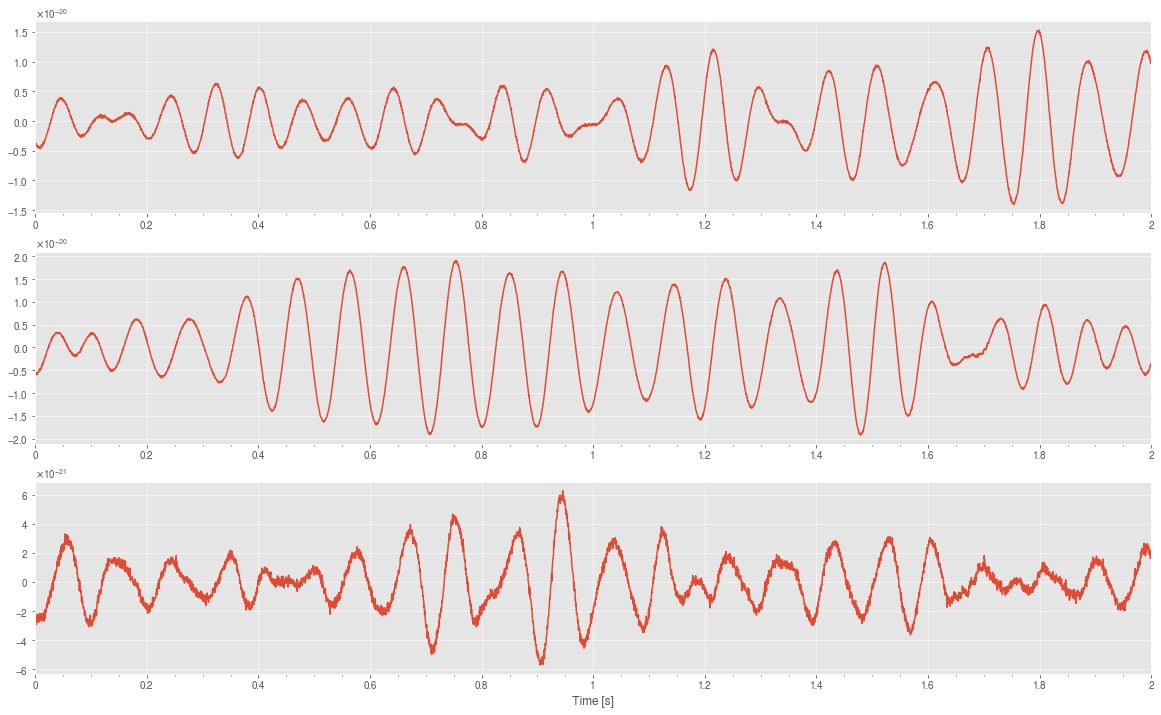

In [20]:
# The gwpy's TimeSeries function expects array-like input data array as its first argument
# and sample_rate : float, Quantity, optional the rate of samples per second (Hertz)
def get_tseries_from_file(file_name):
  t_data = np.load(file_name)
  tseries1 = TimeSeries(t_data[0,:], sample_rate=2048)
  tseries2 = TimeSeries(t_data[1,:], sample_rate=2048)
  tseries3 = TimeSeries(t_data[2,:], sample_rate=2048)
  return tseries1, tseries2, tseries3

''' Multi-data plots with gwpy.plot

https://gwpy.github.io/docs/latest/plot/index.html#multi-data-plots - 

GWpy enables trivial generation of plots with multiple datasets. The Plot constructor will accept an arbitrary collection of data objects and will build a figure with the required geometry automatically. By default, a flat set of objects are shown on the same axes: 

separate=True can be given to show each dataset on a separate Axes

The returned object is a Plot, a sub-class of matplotlib.figure. Figure adapted for GPS time-stamped data. Customisations of the figure or the underlying Axes can be done using standard matplotlib methods. Hence I can use .gca()

.gac() - Get the current Axes instance on the current figure matching the given keyword args, or create one. The plt.gca() function gets the current axes so that you can draw on it directly. 

https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html

'''

def plot_tseries(t1, t2, t3):
  plot = Plot(t1, t2, t3, separate=True, sharex=True, figsize=[20, 12])
  ax = plot.gca()
  ax.set_xlim(0, 2)
  ax.set_xlabel('Time [s]')
  plt.show()
  
file_1 = '../input/g2net-gravitational-wave-detection/train/0/0/0/000a5b6e5c.npy'
  
tseries1, tseries2, tseries3 = get_tseries_from_file(file_1)

# Plotting the 3 TimeSeries
plot_tseries(tseries1, tseries2, tseries3)
  

# Load the .npy files from all the nested folder-structure and get the ids from file names

In [21]:
train_labels = pd.read_csv(root_dir + "/training_labels.csv")
print(Fore.YELLOW + 'Dataset has ', Style.RESET_ALL + "{} Observations".format(train_labels.shape[0]) )

print(Fore.MAGENTA + "Printing first 5 Labels: ", Style.RESET_ALL )
display(train_labels.head())

Dataset has  560000 Observations
Printing first 5 Labels:  


,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1


In [22]:
# Construct a Training dataframe for all the available .npy files 

# Get all the file file path from all 4-labels of nested folder structure
files_paths = glob(root_dir + '/train/*/*/*/*')
''' The glob module finds all the pathnames matching a specified pattern according to the rules 
used by the Unix shell, although results are returned in arbitrary order. 
No tilde expansion is done, but *, ?, and character ranges expressed with [] will be correctly matched. 
We can use glob to search for a specific file pattern, or perhaps more usefully, search for files where the 
filename matches a certain pattern by using wildcard characters.

'''

# get the list of ids from the .npy files
ids_from_npy_files = [path.split("/")[-1].split(".")[0] for path in files_paths]
# [-1] means the last element in a sequence,
# print(ids_from_npy_files)

# get a dataframe with paths and ids of those .npy files
df_path_id = pd.DataFrame({'path': files_paths, 'id':ids_from_npy_files})
df_path_id.head()

# merging that above df with the target
df_train = pd.merge(left=train_labels, right=df_path_id, on='id')
display(df_train.head())

# verifying the shape of the merged df has 5,60,000 rows and 3 columns
print(df_train.shape)


,id,target,path
0,00000e74ad,1,../input/g2net-gravitational-wave-detection/tr...
1,00001f4945,0,../input/g2net-gravitational-wave-detection/tr...
2,0000661522,0,../input/g2net-gravitational-wave-detection/tr...
3,00007a006a,0,../input/g2net-gravitational-wave-detection/tr...
4,0000a38978,1,../input/g2net-gravitational-wave-detection/tr...


(560000, 3)


In [23]:
# Classify the the 2 classes of targets of 1 and 0
target_1_df_train = df_train[df_train.target == 1]
target_0_df_train = df_train[df_train.target == 0]
print("Class distribution of Target: \n ", train_labels.target.value_counts())
display(target_1_df_train.head())

Class distribution of Target: 
  0    280070
1    279930
Name: target, dtype: int64


,id,target,path
0,00000e74ad,1,../input/g2net-gravitational-wave-detection/tr...
4,0000a38978,1,../input/g2net-gravitational-wave-detection/tr...
5,0000bb9f3e,1,../input/g2net-gravitational-wave-detection/tr...
7,0000d61b7b,1,../input/g2net-gravitational-wave-detection/tr...
8,0001016d12,1,../input/g2net-gravitational-wave-detection/tr...


Text(0.5, 1.0, 'Target Class Distribution')

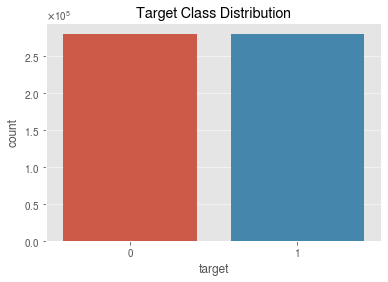

In [24]:
sns.countplot(x = 'target' , data=train_labels)
plt.title('Target Class Distribution')

### Plotting (KDE, Boxplot, and Timeseries)

As we are provided with a train and test set of time series data from a network of 3 gravitational wave interferometers:

- LIGO Hanford

- LIGO Livingston

- Virgo


In [34]:
# Defining a multi-plot function
# And I am going to call the 3 series as Series-1, Series-2 and Series-3
def multi_plot(series, plot_type, target):
    if plot_type == 'box' or plot_type == 'kde':
      plt.figure(figsize=(20, 2))
    else:
      plt.figure(figsize=(15,12))

    for idx in range(3):
      if plot_type == 'box':
          plt.subplot(1, 3, idx+1)
          sns.boxplot(series[idx:idx+1], color = 'b')

      elif plot_type == 'kde':
            plt.subplot(1, 3, idx+1)
            sns.kdeplot(series[idx], color = 'g', shade=True, lw=2, alpha=0.5)
      else:
        plt.subplot(3, 1, idx+1) # As in the case of 'time' based plot, I wan 3 rows
        plt.plot(series[idx: idx+1].T, color= 'r')
        plt.title("\nSeries-" + str(idx+1))

    if plot_type == 'box':
      plt.suptitle("Box Plots(target = " + target + ")")
    elif plot_type == 'kde':
      plt.suptitle("Probability Distribution Plots(target = " + target + ")")
    else:
      plt.suptitle("Time Distribution of Signals - Spans 2 sec, Sampled at 2,048 Hz(target = " + target + ")")
        

  

../input/g2net-gravitational-wave-detection/train/8/b/2/8b2e1fcf1b.npy


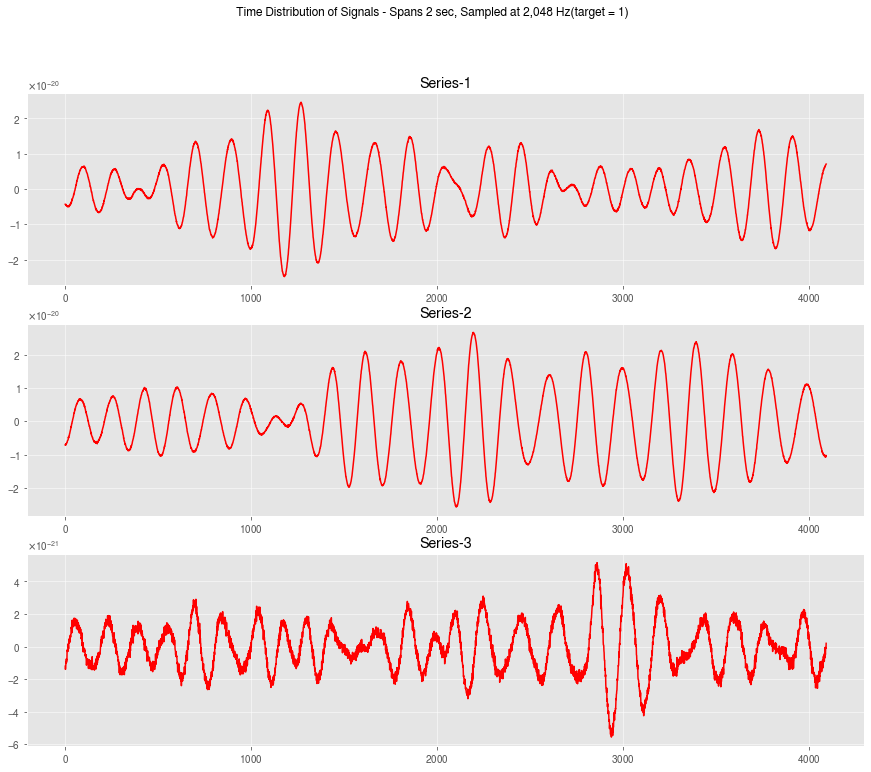

In [26]:
# Extract 1 random element from the target_1_df_train
# using random_state to ensure the reproducibility of the examples.
target_1_rand_sample_file = target_1_df_train.sample(1).path.values[0]
print(target_1_rand_sample_file)

selected_rand_series_1 = np.load(target_1_rand_sample_file)

multi_plot(selected_rand_series_1, 'time', "1")


../input/g2net-gravitational-wave-detection/train/7/2/3/723cec9b26.npy


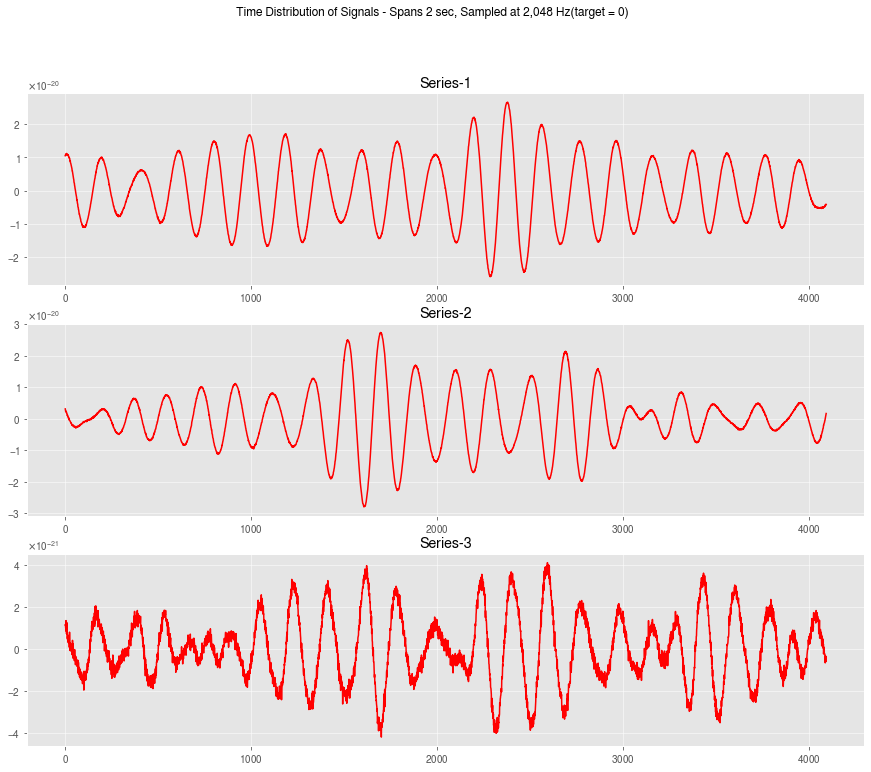

In [27]:
# Extract 1 random element from the target_0_df_train
# using random_state to ensure the reproducibility of the examples.
target_0_rand_sample_file = target_0_df_train.sample(1).path.values[0]
print(target_0_rand_sample_file)

selected_rand_series_0 = np.load(target_0_rand_sample_file)

multi_plot(selected_rand_series_0, 'time', "0")


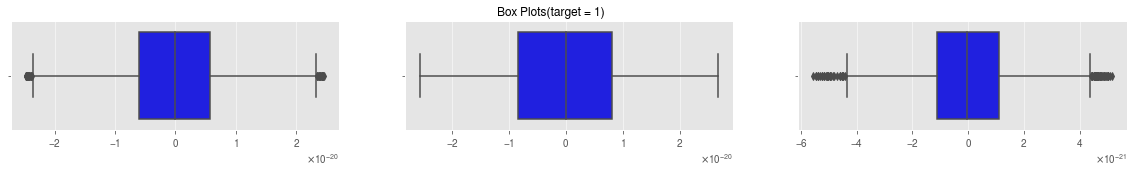

In [28]:
multi_plot(selected_rand_series_1, "box", "1")

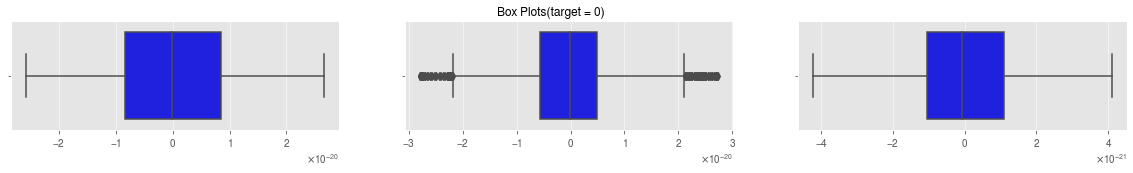

In [29]:
multi_plot(selected_rand_series_0, 'box', "0")

**Basic observation from Box Plots:**
1. The 3 series from the 3 Interferometer have fairly similar distribution for both the class types.

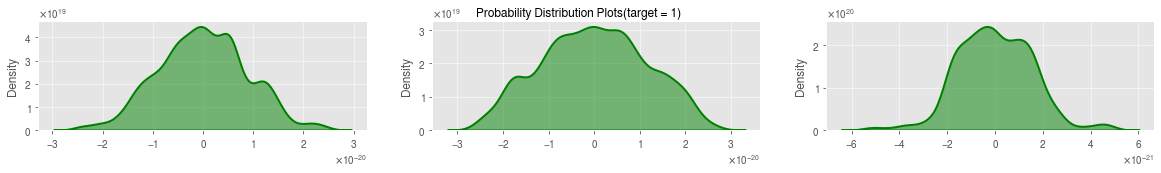

In [36]:
multi_plot(selected_rand_series_1, 'kde', "1")

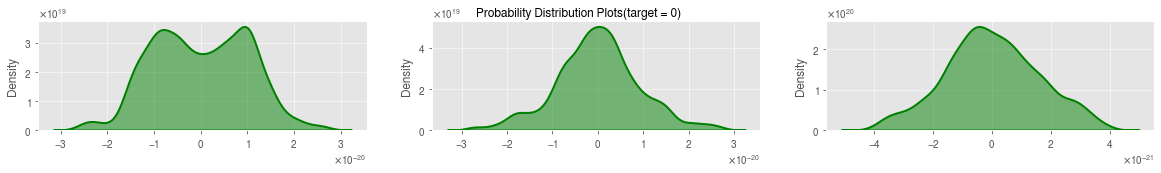

In [37]:
multi_plot(selected_rand_series_0, 'kde', "0")